In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

In [80]:
train_data = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\train.csv")
features = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\features.csv")
patient_notes = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\patient_notes.csv")

### CASE - 4

In [81]:
case_4_features = features[features["case_num"] == 4]
case_4_features

,feature_num,case_num,feature_text
59,400,4,Lack-of-other-thyroid-symptoms
60,401,4,anxious-OR-nervous
61,402,4,Stress-due-to-caring-for-elderly-parents
62,403,4,Heavy-caffeine-use
63,404,4,No-depressed-mood
64,405,4,Weight-stable
65,406,4,Insomnia
66,407,4,Female
67,408,4,Decreased-appetite
68,409,4,45-year


In [82]:
case_4_pn = patient_notes[patient_notes["case_num"] ==  4]
case_4_pn

,pn_num,case_num,pn_history
14787,40000,4,45 year old woman who presents with nervousnes...
14788,40001,4,"45-yo F c/o nervousness for a fw weeks now, it..."
14789,40002,4,45F presenting with 3 weeks nervouness not bro...
14790,40003,4,CC: 45 y/o f c/o nervnousness.\r\nHPI: It star...
14791,40004,4,45 YO F C/O NERVOUSNESS X FEW WEEKS. IT STARTE...
...,...,...,...
20187,45584,4,45 year old female with 2-3 weeks of constant ...
20188,45585,4,"45 yo F, no PMHx presents with 4 weeks of nerv..."
20189,45586,4,45 YEARS OLD FEMALE WITH NERVOUSNESS FOR FEW W...
20190,45587,4,45 YO F C/O NERVOUSNESS AND ANXIETY SINCE 2-3 ...


In [83]:
case_4_train = train_data[train_data["case_num"] == 4]
case_4_train = case_4_train[case_4_train.annotation != '[]']
case_4_train.head()

,id,case_num,pn_num,feature_num,annotation,location
5900,40045_400,4,40045,400,"['denies palpitations', 'denies tremors', 'den...","['468 474;491 503', '468 474;546 553', '468 47..."
5901,40045_401,4,40045,401,"['nervousness', 'nervousness', 'nervousness']","['52 63', '82 93', '206 217']"
5904,40045_404,4,40045,404,['denies any depression'],['468 489']
5905,40045_405,4,40045,405,['denies weight loss'],['468 474;531 542']
5906,40045_406,4,40045,406,['trouble going to sleep'],['354 376']


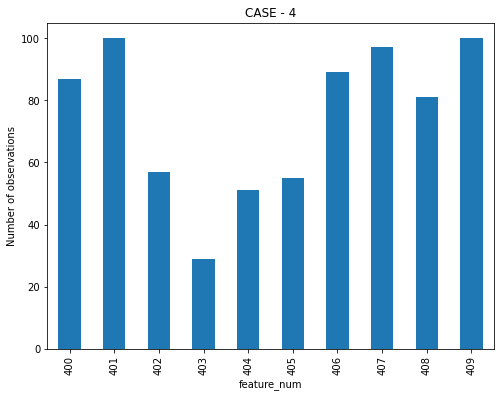

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_4_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 4")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE - 4

In [85]:
pn_dict = {}
for idx, row in case_4_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [86]:
new_annotation = []
for case_id in case_4_features['case_num'].unique():
    
    all_pn_id = set(case_4_pn[case_4_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_4_features[case_4_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_4_train[case_4_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_4_train[case_4_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [87]:
len(new_annotation)

26071

In [88]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,40000_400,4,40000,400,[no palpitations],[322 337]
1,40001_400,4,40001,400,[no palpitations],[516 531]
2,40003_400,4,40003,400,[no c],[551 555]
3,40006_400,4,40006,400,[no weight changes],[287 304]
4,40016_400,4,40016,400,[no palpitations],[634 649]


In [89]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,40000_400,4,40000,400,[no palpitations],[322 337]
1,40001_400,4,40001,400,[no palpitations],[516 531]
2,40003_400,4,40003,400,[no c],[551 555]
3,40006_400,4,40006,400,[no weight changes],[287 304]
4,40016_400,4,40016,400,[no palpitations],[634 649]


In [90]:
df[df.feature_num == 400]

,id,case_num,pn_num,feature_num,annotation,location
0,40000_400,4,40000,400,[no palpitations],[322 337]
1,40001_400,4,40001,400,[no palpitations],[516 531]
2,40003_400,4,40003,400,[no c],[551 555]
3,40006_400,4,40006,400,[no weight changes],[287 304]
4,40016_400,4,40016,400,[no palpitations],[634 649]
...,...,...,...,...,...,...
2370,45577_400,4,45577,400,[no fatigue],[358 368]
2371,45578_400,4,45578,400,"[DENIES TREMOR, DENIES TREMORS]","[269 282, 269 283]"
2372,45584_400,4,45584,400,"[Denies palpitation, Denies palpitations]","[472 490, 472 491]"
2373,45585_400,4,45585,400,"[no c, no d, no palpitations]","[512 516, 876 880, 690 705]"


In [91]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,40000_400,4,40000,400,'no palpitations','322 337'
1,40001_400,4,40001,400,'no palpitations','516 531'
2,40003_400,4,40003,400,'no c','551 555'
3,40006_400,4,40006,400,'no weight changes','287 304'
4,40016_400,4,40016,400,'no palpitations','634 649'


In [92]:
df = df.drop(["id","case_num"],axis = 1)

In [48]:
#denies nausea, vomiting' 152


In [27]:
df_400.head()

,id,case_num,pn_num,feature_num,annotation,location
2181,45161_400,4,45161,400,'denies palpitation','80 98'
2272,45359_400,4,45359,400,"'no heart palpitations', 'no skin changes', 'n...","'344 365', '396 411', '413 428'"
607,41427_400,4,41427,400,"'no c', 'no d', 'no palpitations'","'435 439', '885 889', '375 390'"
931,42172_400,4,42172,400,"'no c', 'no d'","'486 490', '726 730'"
950,42205_400,4,42205,400,"'no fatigue', 'no skin changes'","'318 328', '302 317'"


In [49]:
df_400 = (df_400.set_index(["pn_num","feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_400.columns, axis=1))


In [93]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,feature_num,annotation,location,start_location,end_location
0,40000,400,'no palpitations','322 337',322,337
1,40001,400,'no palpitations','516 531',516,531
2,40003,400,'no c','551 555',551,555
3,40006,400,'no weight changes','287 304',287,304
4,40016,400,'no palpitations','634 649',634,649
...,...,...,...,...,...,...
26066,45584,409,"'45', '45 year', '45 year old'","'0 2', '0 7', '0 11'",0,11
26067,45585,409,"'45', '45 yo'","'0 2', '0 5'",0,5
26068,45586,409,'45','0 2',0,2
26069,45587,409,"'45', '45 YO'","'0 2', '0 5'",0,5


In [94]:
df_400 = df[df["feature_num"] == 400].sample(n = 90, random_state = 150)
df_400.shape

(90, 6)

In [95]:
df_402 = df[df["feature_num"] == 402].sample(n = 130, random_state = 0)
df_402.shape

(130, 6)

In [96]:
df_403 = df[df["feature_num"] == 403].sample(n = 150, random_state = 0)
df_403.shape

(150, 6)

In [97]:
df_404 = df[df["feature_num"] == 404].sample(n = 130, random_state = 0)
df_404.shape

(130, 6)

In [98]:
df_405 = df[df["feature_num"] == 405].sample(n = 130, random_state = 0)
df_405.shape

(130, 6)

In [99]:
df_403

,pn_num,feature_num,annotation,location,start_location,end_location
7920,41072,403,"'5-6 cups of coffee a day', '5-6 cups of coffee'","'741 765', '741 759'",741,759
7892,40858,403,'5-6 cups of coffee','245 263',245,263
8316,43846,403,'5-6 cups of coffee','415 433',415,433
7784,40098,403,'5-6 cups of coffee','432 450',432,450
8312,43806,403,'5-6 cups of coffee','269 287',269,287
...,...,...,...,...,...,...
7926,41097,403,'5-6 cups of coffee','403 421',403,421
7846,40508,403,'drinks 5-6 coffee','212 229',212,229
7834,40445,403,'5-6 cups of coffee','524 542',524,542
8488,45184,403,"'5-6 cups of coffee per day', '5-6 cups of cof...","'266 292', '266 284'",266,284


### Case - 47 Train data

In [100]:
case_4_train = case_4_train[['pn_num','annotation',"location","feature_num"]]

In [101]:
case_4_train["annotation"] = case_4_train.annotation.str.replace('[','')
case_4_train["annotation"] = case_4_train.annotation.str.replace(']','')
case_4_train["location"] = case_4_train.location.str.replace('[','')
case_4_train["location"] = case_4_train.location.str.replace(']','')

case_4_train

,pn_num,annotation,location,feature_num
5900,40045,"'denies palpitations', 'denies tremors', 'deni...","'468 474;491 503', '468 474;546 553', '468 474...",400
5901,40045,"'nervousness', 'nervousness', 'nervousness'","'52 63', '82 93', '206 217'",401
5904,40045,'denies any depression','468 489',404
5905,40045,'denies weight loss','468 474;531 542',405
5906,40045,'trouble going to sleep','354 376',406
...,...,...,...,...
6895,45497,'denies weight loss','494 500;550 561',405
6896,45497,'restless sleep','170 184',406
6897,45497,'woman','47 52',407
6898,45497,'loss of appetite','186 202',408


In [103]:
case_4_train.loc[case_4_train["annotation"] == "'responsibilities at home, caring for elderly mother', 'responsibilities at home, caring for in-laws'","annotation"] = "'responsibilities at home  caring for elderly mother', 'responsibilities at home  caring for in-laws'"
case_4_train.loc[case_4_train["annotation"] == "'stress in her life, ie caring for mother'","annotation"] = "'stress in her life  ie caring for mother'"
case_4_train.loc[case_4_train["annotation"] == "'denies palipations', 'denies tremors', 'denies nausea, vomiting', 'denies diarrhea'","annotation"] = "'denies palipations', 'denies tremors', 'denies nausea  vomiting', 'denies diarrhea'"
case_4_train.loc[case_4_train["annotation"] == "'overwhelmed taking care mother who lives at home with her, and her two in-law parents', 'does activities of daily for all three of her elderly parents', 'feels overwhelmed taking care of her mother two in-law parents'","annotation"] = "'overwhelmed taking care mother who lives at home with her  and her two in-law parents', 'does activities of daily for all three of her elderly parents', 'feels overwhelmed taking care of her mother two in-law parents'"
case_4_train.loc[case_4_train["annotation"] == "'denies hair loss', 'denies hot or cold intolerance', 'denies sweating', 'denies palpitations', 'denies diarrhea', 'denies nausea,vomiting'","annotation"] = "'denies hair loss', 'denies hot or cold intolerance', 'denies sweating', 'denies palpitations', 'denies diarrhea', 'denies nausea vomiting'"
case_4_train.loc[case_4_train["annotation"] == "'Denies sweating', 'Denies consptiation, diarrhea', 'Denies N/V', 'Denies diarrhea', 'no weight changes', 'Denies consptiation'","annotation"] = "'Denies sweating', 'Denies consptiation  diarrhea', 'Denies N/V', 'Denies diarrhea', 'no weight changes', 'Denies consptiation'"
case_4_train.loc[case_4_train["annotation"] == "'a lot of work load caregiver to her in-laws, mother'","annotation"] = "'a lot of work load caregiver to her in-laws  mother'"


In [24]:
case_4_train.loc[case_4_train["annotation"] == "'a lot of work load caregiver to her in-laws, mother'"]

,pn_num,annotation,location,feature_num


In [104]:
case_4_train = (case_4_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(",").explode())
   .reset_index()
   .reindex(case_4_train.columns, axis=1))
case_4_train

,pn_num,annotation,location,feature_num
0,40045,'denies palpitations','468 474;491 503',400
1,40045,'denies tremors','468 474;546 553',400
2,40045,'denies sweatness','468 474;505 514',400
3,40045,'nervousness','52 63',401
4,40045,'nervousness','82 93',401
...,...,...,...,...
1134,45497,'restless sleep','170 184',406
1135,45497,'woman','47 52',407
1136,45497,'loss of appetite','186 202',408
1137,45497,'45 year','15 22',409


In [105]:
case_4_train["start_location"] = case_4_train["location"].apply(lambda x: x.split()[0][1:])
case_4_train["end_location"] = case_4_train["location"].apply(lambda x: x.split()[-1][:-1])
case_4_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,40045,'denies palpitations','468 474;491 503',400,468,503
1,40045,'denies tremors','468 474;546 553',400,468,553
2,40045,'denies sweatness','468 474;505 514',400,468,514
3,40045,'nervousness','52 63',401,52,63
4,40045,'nervousness','82 93',401,82,93
...,...,...,...,...,...,...
1134,45497,'restless sleep','170 184',406,170,184
1135,45497,'woman','47 52',407,47,52
1136,45497,'loss of appetite','186 202',408,186,202
1137,45497,'45 year','15 22',409,15,22


In [106]:
df_405

,pn_num,feature_num,annotation,location,start_location,end_location
9564,42736,405,'No changes in weight','441 461',441,461
9698,43646,405,'Denies weight loss','358 376',358,376
9510,42437,405,'not lost weight','243 258',243,258
9205,40282,405,'no weight changes','353 370',353,370
9806,44452,405,'no weight loss','287 301',287,301
...,...,...,...,...,...,...
9639,43277,405,'no weight changes','618 635',618,635
9406,41657,405,'no changes in weight','472 492',472,492
9889,45084,405,'Denies changes in weight','731 755',731,755
9612,43093,405,'Denies weight loss','329 347',329,347


In [107]:
case_4 = pd.concat([case_4_train,df_400,df_402,df_403,df_404,df_405])
case_4.shape

(1769, 6)

In [108]:
case_4 = case_4.merge(patient_notes, on='pn_num', how='left')
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...
...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,618,635,4,45 y o f c/o of episodes of irriitabilty for f...
1765,41657,'no changes in weight','472 492',405,472,492,4,HPI 45 yo female presented complainnig of nerv...
1766,45084,'Denies changes in weight','731 755',405,731,755,4,Karin Moore is a 45 yo white F with complaint ...
1767,43093,'Denies weight loss','329 347',405,329,347,4,Pt 45 yo F c/o nervousness for the last 3 week...


In [110]:
case_4["New_annotation"] = case_4.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_4.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,"denies any depression, palpitations"
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,"denies any depression, palpitations, sweatness..."
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,"denies any depression, palpitations, sweatness"
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness


In [111]:
case_4["New_annotation"] = case_4["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_4["New_annotation"] = case_4["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_4["New_annotation"] = case_4["New_annotation"].apply(lambda x: x.strip())
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations sweatness...
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations sweatness
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness
...,...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,618,635,4,45 y o f c/o of episodes of irriitabilty for f...,no weight changes
1765,41657,'no changes in weight','472 492',405,472,492,4,HPI 45 yo female presented complainnig of nerv...,no changes in weight
1766,45084,'Denies changes in weight','731 755',405,731,755,4,Karin Moore is a 45 yo white F with complaint ...,Denies changes in weight
1767,43093,'Denies weight loss','329 347',405,329,347,4,Pt 45 yo F c/o nervousness for the last 3 week...,Denies weight loss


In [112]:
case_4["New_pn_history"] = case_4["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_4["New_pn_history"] = case_4["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations,Mrs. Moore is a 45 year old female presenting ...
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations sweatness...,Mrs. Moore is a 45 year old female presenting ...
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitations sweatness,Mrs. Moore is a 45 year old female presenting ...
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...
...,...,...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,618,635,4,45 y o f c/o of episodes of irriitabilty for f...,no weight changes,45 y o f c o of episodes of irriitabilty for f...
1765,41657,'no changes in weight','472 492',405,472,492,4,HPI 45 yo female presented complainnig of nerv...,no changes in weight,HPI 45 yo female presented complainnig of nerv...
1766,45084,'Denies changes in weight','731 755',405,731,755,4,Karin Moore is a 45 yo white F with complaint ...,Denies changes in weight,Karin Moore is a 45 yo white F with complaint ...
1767,43093,'Denies weight loss','329 347',405,329,347,4,Pt 45 yo F c/o nervousness for the last 3 week...,Denies weight loss,Pt 45 yo F c o nervousness for the last 3 week...


In [113]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [114]:
case_4["New_annotation"] = case_4["New_annotation"].apply(word_lemm)
case_4["New_pn_history"] = case_4["New_pn_history"].apply(word_lemm)
case_4.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation,Mrs. Moore is a 45 year old female presenting ...
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness pa...,Mrs. Moore is a 45 year old female presenting ...
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness,Mrs. Moore is a 45 year old female presenting ...
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...


In [115]:
case_4["new_location"] = case_4.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 494), match='deni..."
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness pa...,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 539), match='deni..."
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 504), match='deni..."
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
...,...,...,...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,618,635,4,45 y o f c/o of episodes of irriitabilty for f...,no weight change,45 y o f c o of episode of irriitabilty for fe...,"<re.Match object; span=(596, 612), match='no w..."
1765,41657,'no changes in weight','472 492',405,472,492,4,HPI 45 yo female presented complainnig of nerv...,no change in weight,HPI 45 yo female presented complainnig of nerv...,"<re.Match object; span=(464, 483), match='no c..."
1766,45084,'Denies changes in weight','731 755',405,731,755,4,Karin Moore is a 45 yo white F with complaint ...,Denies change in weight,Karin Moore is a 45 yo white F with complaint ...,"<re.Match object; span=(726, 749), match='Deni..."
1767,43093,'Denies weight loss','329 347',405,329,347,4,Pt 45 yo F c/o nervousness for the last 3 week...,Denies weight loss,Pt 45 yo F c o nervousness for the last 3 week...,"<re.Match object; span=(324, 342), match='Deni..."


In [116]:
drop_index = []
for index,row in case_4.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[82, 84, 129, 309, 310, 311, 312, 313, 318, 330, 632, 693, 694, 695, 700, 701, 760, 848, 850, 913, 915, 920, 955, 957, 1015, 1025, 1045, 1046, 1052, 1140, 1142, 1148, 1150, 1151, 1155, 1157, 1158, 1159, 1165, 1167, 1168, 1169, 1171, 1172, 1175, 1176, 1180, 1181, 1182, 1185, 1188, 1189, 1192, 1193, 1194, 1195, 1196, 1198, 1199, 1200, 1208, 1210, 1214, 1216, 1218, 1221, 1222, 1228, 1538]


(None, 69)

In [117]:
case_4 = case_4.drop(drop_index,axis = 0)
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,40045,'denies palpitations','468 474;491 503',400,468,503,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 494), match='deni..."
1,40045,'denies tremors','468 474;546 553',400,468,553,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness pa...,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 539), match='deni..."
2,40045,'denies sweatness','468 474;505 514',400,468,514,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 504), match='deni..."
3,40045,'nervousness','52 63',401,52,63,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
4,40045,'nervousness','82 93',401,82,93,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
...,...,...,...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,618,635,4,45 y o f c/o of episodes of irriitabilty for f...,no weight change,45 y o f c o of episode of irriitabilty for fe...,"<re.Match object; span=(596, 612), match='no w..."
1765,41657,'no changes in weight','472 492',405,472,492,4,HPI 45 yo female presented complainnig of nerv...,no change in weight,HPI 45 yo female presented complainnig of nerv...,"<re.Match object; span=(464, 483), match='no c..."
1766,45084,'Denies changes in weight','731 755',405,731,755,4,Karin Moore is a 45 yo white F with complaint ...,Denies change in weight,Karin Moore is a 45 yo white F with complaint ...,"<re.Match object; span=(726, 749), match='Deni..."
1767,43093,'Denies weight loss','329 347',405,329,347,4,Pt 45 yo F c/o nervousness for the last 3 week...,Denies weight loss,Pt 45 yo F c o nervousness for the last 3 week...,"<re.Match object; span=(324, 342), match='Deni..."


In [118]:
case_4["start_location"] = case_4.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_4["end_location"] = case_4.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_4

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,40045,'denies palpitations','468 474;491 503',400,461,494,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 494), match='deni..."
1,40045,'denies tremors','468 474;546 553',400,461,539,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness pa...,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 539), match='deni..."
2,40045,'denies sweatness','468 474;505 514',400,461,504,4,Mrs. Moore is a 45 year old female presenting ...,denies any depression palpitation sweatness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(461, 504), match='deni..."
3,40045,'nervousness','52 63',401,51,62,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
4,40045,'nervousness','82 93',401,51,62,4,Mrs. Moore is a 45 year old female presenting ...,nervousness,Mrs. Moore is a 45 year old female presenting ...,"<re.Match object; span=(51, 62), match='nervou..."
...,...,...,...,...,...,...,...,...,...,...,...
1764,43277,'no weight changes','618 635',405,596,612,4,45 y o f c/o of episodes of irriitabilty for f...,no weight change,45 y o f c o of episode of irriitabilty for fe...,"<re.Match object; span=(596, 612), match='no w..."
1765,41657,'no changes in weight','472 492',405,464,483,4,HPI 45 yo female presented complainnig of nerv...,no change in weight,HPI 45 yo female presented complainnig of nerv...,"<re.Match object; span=(464, 483), match='no c..."
1766,45084,'Denies changes in weight','731 755',405,726,749,4,Karin Moore is a 45 yo white F with complaint ...,Denies change in weight,Karin Moore is a 45 yo white F with complaint ...,"<re.Match object; span=(726, 749), match='Deni..."
1767,43093,'Denies weight loss','329 347',405,324,342,4,Pt 45 yo F c/o nervousness for the last 3 week...,Denies weight loss,Pt 45 yo F c o nervousness for the last 3 week...,"<re.Match object; span=(324, 342), match='Deni..."


### Feature 400

In [119]:
case_4_400 = case_4[case_4["feature_num"] == 400]
case_4_400.shape

(292, 11)

In [120]:
drop_400 = [0,2,12,13,14,15,25,44,45,46,85,98,99,625,108,109,110,120,121,122,145,154,155,156,173,187,188,189,190,220,221,
           235,414,415,259,260,261,262,288,301,302,324,350,351,365,391,392,393,394,427,428,445,446,456,457,471,472,473,474,
            475,476,489,490,491,501,502,514,591,521,522,523,540,541,542,543,859,554,555,556,557,569,582,583,599,611,647,
           662,663,664,707,708,717,718,729,746,753,755,756,776,777,787,788,789,805,824,825,826,827,852,880,930,943,944,945,
            946,947,978,987,993,994,1018,1019,1028,1029,1031,1032,1033,1044,1064,1065,1066,1067,1084,1104,1115,1117,1126]

In [121]:
case_4_400 = case_4_400.drop(drop_400)

In [122]:
pn_Num_list = list(case_4_400.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_400[case_4_400.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_400[case_4_400.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_400.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_400.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(108, 28)

In [123]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_400.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 209.00it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [124]:
case_4_400[case_4_400.start_location == 485]

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
1127,45497,'denies changes in gastrointestinal patterns','494 500;512 548',400,485,535,4,"Ms. Moore is a 45 year old, previously healthy...",denies headache change in gastrointestinal pat...,Ms. Moore is a 45 year old previously healthy ...,"<re.Match object; span=(485, 535), match='deni..."


In [125]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_400.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 384.43it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [126]:
!python -m spacy init fill-config ./base_config_400.cfg ./config_400.cfg

[+] Auto-filled config with all values
[+] Saved config
config_400.cfg
You can now add your data and train your pipeline:
python -m spacy train config_400.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-09 15:20:57.806905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:20:57.807120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [127]:
!python -m spacy train config_400.cfg --output ./output_400

[i] Saving to output directory: output_400
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.17    0.00    0.00    0.00    0.00
  1     200       4145.81   2108.45   18.87   14.71   26.32    0.19
  3     400         41.24    340.20   22.86   15.69   42.11    0.23
  5     600         99.49    249.04   24.32   16.36   47.37    0.24
  7     800        104.04    142.94   31.37   25.00   42.11    0.31
  9    1000         92.49     93.00   30.77   24.24   42.11    0.31
 11    1200        114.75     78.94   26.23   19.05   42.11    0.26
 12    1400        105.40     57.45   35.62   24.07   68.42    0.36
 14    1600      

2022-05-09 15:21:45.268181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:21:45.268233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-09 15:21:51,383] [INFO] Set up nlp object from config
[2022-05-09 15:21:51,398] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-09 15:21:51,403] [INFO] Created vocabulary
[2022-05-09 15:21:51,479] [INFO] Finished initializing nlp object
[2022-05-09 15:21:52,771] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 401

In [236]:
case_4_401 = case_4[case_4["feature_num"] == 401]
case_4_401.shape

(227, 11)

In [237]:
drop_401 = [4,5,135,1035,35,210,721,48,76,147,207,317,971,289,459,329,417,431,449,949,328,792,336,614,615,367,733,735,
           559,560,573,593,601,652,653,697,699,748,768,830,831,832,869,870,893,894,895,896,970,1011,1013,1057,1058,
           1109,1108,1107,1106,1130,950,1086,1087]

In [238]:
case_4_401 = case_4_401.drop(drop_401)

In [239]:
pn_Num_list = list(case_4_401.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_401[case_4_401.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_401[case_4_401.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_401.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_401.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(80, 20)

In [240]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_401.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 317.05it/s]


In [241]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_401.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 455.74it/s]


In [242]:
!python -m spacy init fill-config ./base_config_401.cfg ./config_401.cfg

[+] Auto-filled config with all values
[+] Saved config
config_401.cfg
You can now add your data and train your pipeline:
python -m spacy train config_401.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 00:23:12.361710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 00:23:12.361866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [243]:
!python -m spacy train config_401.cfg --output ./output_401

[+] Created output directory: output_401
[i] Saving to output directory: output_401
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.33    0.34    0.18    2.70    0.00
  2     200         38.12   1196.49   66.67   75.86   59.46    0.67
  5     400         74.21    143.52   68.66   76.67   62.16    0.69

2022-05-06 00:24:06.563317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 00:24:06.563369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 00:24:12,660] [INFO] Set up nlp object from config
[2022-05-06 00:24:12,674] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 00:24:12,680] [INFO] Created vocabulary
[2022-05-06 00:24:12,712] [INFO] Finished initializing nlp object
[2022-05-06 00:24:13,918] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



  7     600         50.43     63.77   66.67   75.86   59.46    0.67
 10     800         60.17     58.54   70.27   70.27   70.27    0.70
 12    1000         62.12     52.59   65.67   73.33   59.46    0.66
 15    1200         59.26     44.24   59.26   94.12   43.24    0.59
 17    1400         54.29     44.79   64.62   75.00   56.76    0.65
 20    1600         30.91     34.27   71.43   75.76   67.57    0.71
 22    1800        275.18     51.54   63.77   68.75   59.46    0.64
 26    2000        143.32     59.26   67.50   62.79   72.97    0.68
 31    2200         80.92     59.77   64.52   80.00   54.05    0.65
 38    2400         65.24     45.22   63.89   65.71   62.16    0.64
 46    2600        111.74     53.13   45.28   75.00   32.43    0.45
 57    2800         64.18     54.25   60.71   89.47   45.95    0.61
 69    3000         86.88     61.86   67.69   78.57   59.46    0.68
 84    3200         38.74     60.33   69.84   84.62   59.46    0.70
[+] Saved pipeline to output directory
output_4

### Feature 402

In [444]:
case_4_402 = case_4[case_4["feature_num"] == 402]
case_4_402.shape

(203, 11)

In [445]:
drop_402 = [79,113,177,369,432,685,780,809,842,933,962,1255]

In [446]:
case_4_402 = case_4_402.drop(drop_402)

In [447]:
pn_Num_list = list(case_4_402.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_402[case_4_402.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_402[case_4_402.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_402.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_402.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(148, 37)

In [448]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_402.spacy")

 29%|███████████████████████▏                                                        | 43/148 [00:00<00:00, 214.38it/s]

Skipping entity


100%|███████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 341.01it/s]


In [449]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_402.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 394.65it/s]


In [450]:
!python -m spacy init fill-config ./base_config_402.cfg ./config_402.cfg

[+] Auto-filled config with all values
[+] Saved config
config_402.cfg
You can now add your data and train your pipeline:
python -m spacy train config_402.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 17:58:46.667088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 17:58:46.667139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [451]:
!python -m spacy train config_402.cfg --output ./output_402

[+] Created output directory: output_402

2022-05-06 17:58:59.371140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 17:58:59.371191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 17:59:05,777] [INFO] Set up nlp object from config
[2022-05-06 17:59:05,799] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 17:59:05,808] [INFO] Created vocabulary
[2022-05-06 17:59:05,843] [INFO] Finished initializing nlp object
[2022-05-06 17:59:07,299] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_402
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     47.00    0.00    0.00    0.00    0.00
  1     200       2014.25   2112.41    0.00    0.00    0.00    0.00
  2     400        161.47    347.19   58.54   53.33   64.86    0.59
  4     600      11897.55    431.20   67.65   74.19   62.16    0.68
  5     800        942.59    261.40   69.44   71.43   67.57    0.69
  6    1000        406.30    184.93   72.00   71.05   72.97    0.72
  8    1200        137.48    158.58   77.92   75.00   81.08    0.78
  9    1400        125.95    114.32   71.05   69.23   72.97    0.71
 10    1600     

### Feature 403

In [452]:
case_4_403 = case_4[case_4["feature_num"] == 403]
case_4_403.shape

(181, 11)

In [453]:
drop_403 = [341,561,1283,1305,1292,1294,1295,1401,1331,1332,1349]

In [454]:
case_4_403 = case_4_403.drop(drop_403)

In [455]:
pn_Num_list = list(case_4_403.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_403[case_4_403.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_403[case_4_403.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_403.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_403.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(135, 34)

In [456]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_403.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 434.73it/s]


In [191]:
#train[102]

In [192]:
#case_4_403[case_4_403.start_location == 196]

In [457]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_403.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 473.48it/s]


In [458]:
!python -m spacy init fill-config ./base_config_403.cfg ./config_403.cfg

[+] Auto-filled config with all values
[+] Saved config
config_403.cfg
You can now add your data and train your pipeline:
python -m spacy train config_403.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 18:10:55.733922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:10:55.733972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [459]:
!python -m spacy train config_403.cfg --output ./output_403

[+] Created output directory: output_403

2022-05-06 18:11:04.054056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:11:04.054109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 18:11:10,028] [INFO] Set up nlp object from config
[2022-05-06 18:11:10,041] [INFO] Pipeline: ['tok2vec', 'ner']



[i] Saving to output directory: output_403
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.33    0.00    0.00    0.00    0.00
  1     200        124.94   1363.16   53.52   51.35   55.88    0.54
  2     400        108.95    226.94   53.52   51.35   55.88    0.54
  4     600         56.20    171.99   75.00   71.05   79.41    0.75
  5     800         77.52    164.09   64.79   62.16   67.65    0.65
  7    1000         65.73    144.42   58.82   58.82   58.82    0.59
  8    1200         96.36    128.59   66.67   63.16   70.59    0.67
 10    1400        134.86    124.99   67.61   64.86   70.59    0.68
 11    1600     

[2022-05-06 18:11:10,047] [INFO] Created vocabulary
[2022-05-06 18:11:10,048] [INFO] Finished initializing nlp object
[2022-05-06 18:11:11,014] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 404

In [128]:
case_4_404 = case_4[case_4["feature_num"] == 404]
case_4_404.shape

(239, 11)

In [129]:
drop_404 = [30,1076,61,62,89,91,126,127,139,164,180,181,195,224,226,227,265,276,278,293,294,1073,343,344,
            436,437,438,462,463,508,509,575,618,687,738,761,763,797,799,885,886,887,908,909,1038,
           1050,1051,1121]

In [130]:
case_4_404 = case_4_404.drop(drop_404)

In [131]:
pn_Num_list = list(case_4_404.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_404[case_4_404.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_404[case_4_404.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_404.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_404.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(143, 36)

In [132]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_404.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 433.20it/s]

Skipping entity
Skipping entity


In [465]:
#validation[9]

In [466]:
#case_4_404[case_4_404.start_location == 329]

In [133]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_404.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 487.77it/s]


In [134]:
!python -m spacy init fill-config ./base_config_404.cfg ./config_404.cfg

[+] Auto-filled config with all values

2022-05-09 15:39:32.337892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:39:32.337944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_404.cfg
You can now add your data and train your pipeline:
python -m spacy train config_404.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [135]:
!python -m spacy train config_404.cfg --output ./output_404

[i] Saving to output directory: output_404
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.50    0.00    0.00    0.00    0.00


2022-05-09 15:39:41.257186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:39:41.257237: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-09 15:39:48,186] [INFO] Set up nlp object from config
[2022-05-09 15:39:48,200] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-09 15:39:48,206] [INFO] Created vocabulary
[2022-05-09 15:39:48,207] [INFO] Finished initializing nlp object
[2022-05-09 15:39:49,131] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


  1     200       1050.63   2081.88   34.04   27.59   44.44    0.34
  2     400         47.60    279.27   79.49   73.81   86.11    0.79
  4     600        393.30    220.19   75.68   73.68   77.78    0.76
  5     800        104.09    144.04   78.95   75.00   83.33    0.79
  6    1000        114.10    140.94   57.14   45.16   77.78    0.57
  8    1200        119.81     98.65   69.23   64.29   75.00    0.69
  9    1400         74.43     64.60   80.00   76.92   83.33    0.80
 11    1600      16430.22    114.24   73.97   72.97   75.00    0.74
 12    1800       5081.07    100.47   85.33   82.05   88.89    0.85
 14    2000        355.63     76.02   78.48   72.09   86.11    0.78
 17    2200        260.01     69.38   64.44   53.70   80.56    0.64
 21    2400        196.59     61.04   70.00   63.64   77.78    0.70
 25    2600         77.76     19.87   72.50   65.91   80.56    0.73
 31    2800        259.95      9.32   73.42   67.44   80.56    0.73
 38    3000        290.64     23.22   74.07   66

### Feature 405

In [136]:
case_4_405 = case_4[case_4["feature_num"] == 405]
case_4_405.shape

(185, 11)

In [137]:
drop_405 = [19,481,953]

In [138]:
case_4_405 = case_4_405.drop(drop_405)

In [139]:
pn_Num_list = list(case_4_405.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_405[case_4_405.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_405[case_4_405.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_405.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_405.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(145, 37)

In [140]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_405.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 445.84it/s]


In [141]:
#validation[4]

In [142]:
#case_4_405[case_4_405.start_location == 537]

In [143]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_405.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 475.45it/s]


In [144]:
!python -m spacy init fill-config ./base_config_405.cfg ./config_405.cfg

[+] Auto-filled config with all values

2022-05-09 15:47:36.782002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:47:36.782055: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_405.cfg
You can now add your data and train your pipeline:
python -m spacy train config_405.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [145]:
!python -m spacy train config_405.cfg --output ./output_405

[i] Saving to output directory: output_405
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline


2022-05-09 15:47:44.979245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-09 15:47:44.979311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-09 15:47:50,837] [INFO] Set up nlp object from config
[2022-05-09 15:47:50,853] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-09 15:47:50,858] [INFO] Created vocabulary
[2022-05-09 15:47:50,860] [INFO] Finished initializing nlp object
[2022-05-09 15:47:51,767] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     43.67    0.00    0.00    0.00    0.00
  1     200        909.35   1670.87   75.00   77.14   72.97    0.75
  2     400        885.22    178.60   77.33   76.32   78.38    0.77
  4     600        174.63    133.87   86.84   84.62   89.19    0.87
  5     800       7551.45    162.95   86.49   86.49   86.49    0.86
  6    1000         90.30     77.97   89.19   89.19   89.19    0.89
  8    1200         62.43     55.22   82.93   75.56   91.89    0.83
  9    1400         46.11     35.57   77.11   69.57   86.49    0.77
 11    1600         41.21     25.67   90.91   87.50   94.59    0.91
 12    1800         31.75      6.88   88.61   83.33   94.59    0.89
 14    2000         41.35     14.17   80.5

### Feature 406

In [490]:
case_4_406 = case_4[case_4["feature_num"] == 406]
case_4_406.shape

(96, 11)

In [491]:
pn_Num_list = list(case_4_406.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_406[case_4_406.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_406[case_4_406.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_406.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_406.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(70, 18)

In [492]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_406.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 199.96it/s]


In [493]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_406.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 300.82it/s]


In [494]:
!python -m spacy init fill-config ./base_config_406.cfg ./config_406.cfg

[+] Auto-filled config with all values

2022-05-06 18:38:12.625693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:38:12.625744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_406.cfg
You can now add your data and train your pipeline:
python -m spacy train config_406.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [495]:
!python -m spacy train config_406.cfg --output ./output_406

[+] Created output directory: output_406

2022-05-06 18:38:21.015373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:38:21.015428: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 18:38:26,973] [INFO] Set up nlp object from config
[2022-05-06 18:38:26,994] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 18:38:27,001] [INFO] Created vocabulary
[2022-05-06 18:38:27,002] [INFO] Finished initializing nlp object
[2022-05-06 18:38:27,735] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_406
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.17    0.00    0.00    0.00    0.00
  2     200        496.46   1484.48   78.79  100.00   65.00    0.79
  5     400         64.17     58.35   84.21   88.89   80.00    0.84
  8     600         92.36     27.64   83.33   93.75   75.00    0.83
 11     800       5239.09     70.01   80.00   93.33   70.00    0.80
 14    1000         59.56     10.99   80.00   93.33   70.00    0.80
 17    1200         13.53     11.84   86.49   94.12   80.00    0.86
 20    1400       1607.33     19.18   86.49   94.12   80.00    0.86
 22    1600     

### Feature 407

In [496]:
case_4_407 = case_4[case_4["feature_num"] == 407]
case_4_407.shape

(91, 11)

In [497]:
drop_407 = [423]

In [498]:
case_4_407 = case_4_407.drop(drop_407)

In [499]:
pn_Num_list = list(case_4_407.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_407[case_4_407.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_407[case_4_407.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_407.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_407.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(72, 18)

In [500]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_407.spacy")

 78%|███████████████████████████████████████████████████████████████                  | 56/72 [00:00<00:00, 244.44it/s]

Skipping entity
Skipping entity


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 289.09it/s]


In [501]:
#train[36]

In [502]:
#case_4_407[case_4_407.start_location == 17]

In [503]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_407.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 200.54it/s]


In [504]:
!python -m spacy init fill-config ./base_config_407.cfg ./config_407.cfg

[+] Auto-filled config with all values
[+] Saved config
config_407.cfg
You can now add your data and train your pipeline:
python -m spacy train config_407.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 18:46:16.848718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:46:16.848770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [505]:
!python -m spacy train config_407.cfg --output ./output_407

[+] Created output directory: output_407
[i] Saving to output directory: output_407
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.83    0.00    0.00    0.00    0.00
  2     200          4.24   1003.42   94.44   94.44   94.44    0.94
  5     400          2.84      8.22  100.00  100.00  100.00    1.00
  8     600          2.34      5.64  100.00  100.00  100.00    1.00
 11     800          4.65      6.09  100.00  100.00  100.00    1.00
 13    1000          2.23      4.00  100.00  100.00  100.00    1.00
 16    1200          1.78      5.44  100.00  100.00  100.00    1.00
 19    1400          2.84      7.15  100.00 

2022-05-06 18:46:26.140902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:46:26.140952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 18:46:32,522] [INFO] Set up nlp object from config
[2022-05-06 18:46:32,542] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 18:46:32,550] [INFO] Created vocabulary
[2022-05-06 18:46:32,552] [INFO] Finished initializing nlp object
[2022-05-06 18:46:33,514] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 408

In [506]:
case_4_408 = case_4[case_4["feature_num"] == 408]
case_4_408.shape

(85, 11)

In [507]:
drop_408 = [380,486,645,938]

In [508]:
case_4_408 = case_4_408.drop(drop_408)

In [509]:
pn_Num_list = list(case_4_408.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_408[case_4_408.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_408[case_4_408.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_408.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_408.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(64, 17)

In [510]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_408.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 297.56it/s]


In [511]:
#case_4_408 = case_4_408.drop([938])

In [512]:
#validation[3]

In [513]:
#case_4_408[case_4_408.end_location == 546]

In [514]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_408.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 139.96it/s]


In [515]:
!python -m spacy init fill-config ./base_config_408.cfg ./config_408.cfg

[+] Auto-filled config with all values
[+] Saved config
config_408.cfg
You can now add your data and train your pipeline:
python -m spacy train config_408.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 18:52:24.002273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:52:24.002323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [516]:
!python -m spacy train config_408.cfg --output ./output_408

[+] Created output directory: output_408

2022-05-06 18:52:33.472734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:52:33.472786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 18:52:40,022] [INFO] Set up nlp object from config
[2022-05-06 18:52:40,040] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 18:52:40,046] [INFO] Created vocabulary
[2022-05-06 18:52:40,048] [INFO] Finished initializing nlp object
[2022-05-06 18:52:41,101] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_408
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.50    0.00    0.00    0.00    0.00
  3     200       2461.93   1239.80   73.33   84.62   64.71    0.73
  6     400       1410.75    165.95   70.97   78.57   64.71    0.71
  9     600        346.08     40.29   75.86   91.67   64.71    0.76
 12     800        453.12     47.32   82.76  100.00   70.59    0.83
 15    1000         19.88     13.36   70.97   78.57   64.71    0.71
 18    1200         30.62     20.85   75.00   80.00   70.59    0.75
 21    1400         30.25     12.87   77.42   85.71   70.59    0.77
 25    1600     

# Feature 409

In [517]:
case_4_409 = case_4[case_4["feature_num"] == 409]
case_4_409.shape

(100, 11)

In [518]:
drop_409 = [425,941,1082,1138]

In [519]:
case_4_409 = case_4_409.drop(drop_409)

In [520]:
pn_Num_list = list(case_4_409.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_4_409[case_4_409.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_4_409[case_4_409.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_409.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_409.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(76, 20)

In [521]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_409.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 218.64it/s]


In [522]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_409.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 364.60it/s]


In [523]:
!python -m spacy init fill-config ./base_config_409.cfg ./config_409.cfg

[+] Auto-filled config with all values
[+] Saved config
config_409.cfg
You can now add your data and train your pipeline:
python -m spacy train config_409.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 18:59:51.512045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 18:59:51.512097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [524]:
!python -m spacy train config_409.cfg --output ./output_409

[+] Created output directory: output_409
[i] Saving to output directory: output_409
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.83    0.10    0.05    5.00    0.00
  2     200      25919.99   3133.32   85.71   81.82   90.00    0.86
  5     400         21.00     66.83   73.17   71.43   75.00    0.73
  7     600         19.26     61.77   80.00   80.00   80.00    0.80
 10     800         13.25     38.02   82.93   80.95   85.00    0.83
 13    1000         13.24     44.29   87.80   85.71   90.00    0.88
 15    1200          9.18     37.92   87.80   85.71   90.00    0.88
 18    1400         18.12     40.40   90.00 

2022-05-06 19:00:02.012390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 19:00:02.012441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 19:00:08,916] [INFO] Set up nlp object from config
[2022-05-06 19:00:08,939] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 19:00:08,946] [INFO] Created vocabulary
[2022-05-06 19:00:08,949] [INFO] Finished initializing nlp object
[2022-05-06 19:00:09,995] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
